In [5]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import time
from pickle import load
import tensorflow as tf
from tensorflow import keras

tf.random.set_seed(42)
K = keras.backend

from sklearn.preprocessing import StandardScaler,PowerTransformer
import math
from scipy.stats import multivariate_normal
from scipy.stats import norm
import os
import pickle

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import scipy.optimize

In [6]:
k = 8
J = 32
save_time_step = 0.005
h=1 
c=10
b=10


# 1. Prepare data for training with differing F values

In [7]:
train1 = np.load("../../data/truth_run/climate_change_exp/train_set_1.npy")
train2 = np.load("../../data/truth_run/climate_change_exp/train_set_2.npy")
train3 = np.load("../../data/truth_run/climate_change_exp/train_set_3.npy")
f20 = np.load("../../data/truth_run/training_dataset.npy")
train4 = np.concatenate([f20, 20*np.ones(shape=(f20.shape[0],k,1))],axis=2)[:200000]

def u_deriver(x_train,F,save_time_step=save_time_step):
    u_t = -np.roll(x_train[:-1,:],1,axis=1) * (np.roll(x_train[:-1,:],2,axis=1) - np.roll(x_train[:-1,:],-1,axis=1)) - x_train[:-1,:] + F -(x_train[1:,:] - x_train[:-1,:])/save_time_step
    return u_t

u_t_train_1 = u_deriver(train1[:,:,0],train1[0,0,-1])
u_t_train_2 = u_deriver(train2[:,:,0],train2[0,0,-1])
u_t_train_3 = u_deriver(train3[:,:,0],train3[0,0,-1])
u_t_train_4 = u_deriver(train4[:,:,0],train4[0,0,-1])

x_combo = np.ravel(np.concatenate([train1[:-1,:,0],train2[:-1,:,0],train3[:-1,:,0],train4[:-1,:,0]],axis=0)).reshape(-1,1)


u_combo = np.ravel(np.concatenate([u_t_train_1,u_t_train_2,u_t_train_3,u_t_train_4],axis=0)).reshape(-1,1)




In [8]:
u_combo_no_ravel = np.concatenate([u_t_train_1,u_t_train_2,u_t_train_3,u_t_train_4],axis=0)

poly = PolynomialFeatures(degree=3,include_bias=True)

x_t_poly = poly.fit_transform(x_combo)

reg = LinearRegression(fit_intercept=False)

reg.fit(x_t_poly,u_combo)

LinearRegression(fit_intercept=False)

In [9]:
reg.coef_

array([[ 0.33066235,  1.29657398, -0.01247788, -0.00233539]])

In [10]:
u_combo.shape

(3999992, 1)

In [11]:
x_combo[:-1,:].shape

(3999991, 1)

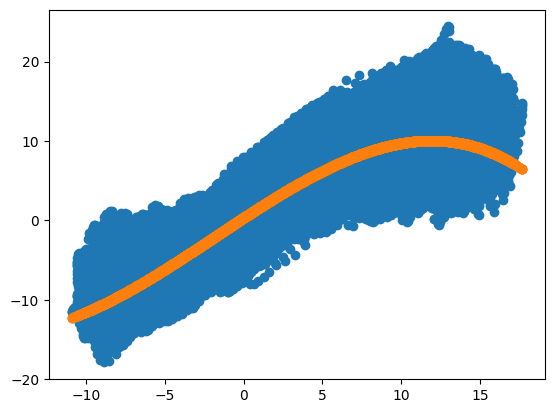

In [32]:


plt.figure()
plt.scatter(x=np.ravel(x_combo[:,:]),y=np.ravel(u_combo[:]))
plt.scatter(x=np.ravel(x_combo[:,:]),y=reg.predict(x_t_poly[:]))
plt.show()

In [21]:
x = np.linspace(-20,30)

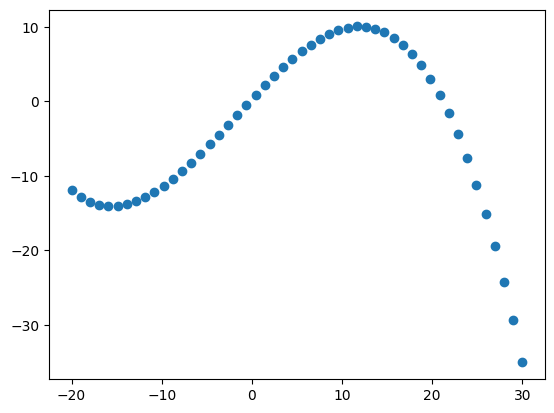

In [27]:
plt.scatter(x=x,y=reg.predict(poly.transform(x.reshape(-1,1))))

In [12]:
u_t_pred = reg.predict(x_t_poly).reshape(-1,k)

In [13]:
residual =  u_combo_no_ravel - u_t_pred

In [14]:


h_t = np.ravel(residual[1:,:])
h_t_minus1 = np.ravel(residual[:-1,:])



In [14]:


# need to find optimum sigma and phi values. Model as normally distributed variable h_t, and then maximise loglik

def loglik(h_t,h_t_minus1,theta):
    tau,rho = theta
    sigma = np.exp(tau) # ensures sigma is positive
    phi = np.exp(rho) / (1+ np.exp(rho)) #ensures phi is between 0 and 1
    lik = norm.pdf(h_t,loc=phi*h_t_minus1,scale=sigma*(1-phi**2)**0.5)
    return np.log(lik)



In [15]:
initial_guess = [0.7,4]

In [16]:
theta_mle = scipy.optimize.fmin(lambda theta: -np.sum(loglik(h_t,h_t_minus1,theta)), initial_guess, maxiter=5000)

Optimization terminated successfully.
         Current function value: 1344451.876842
         Iterations: 32
         Function evaluations: 60


In [17]:
theta_mle

array([0.69891197, 4.23509231])

In [18]:
phi = np.exp(theta_mle[1]) / (1+np.exp(theta_mle[1]))
phi


0.9857281607542057

In [19]:
sigma = np.exp(theta_mle[0])
sigma


2.0115628798707323

# 2. Eval of holdout likelihood

In [15]:
def _rhs_X_dt(X, F,U,dt=0.005):
    """Compute the right hand side of the X-ODE."""

    dXdt = (-np.roll(X, 1,axis=1) * (np.roll(X, 2,axis=1) - np.roll(X, -1,axis=1)) -
                X + F - U)

    return dt * dXdt 


def U(Xt,Xt_1,F,dt=0.005):
    k1_X = _rhs_X_dt(Xt,F,U=0)
    k2_X = _rhs_X_dt(Xt + k1_X / 2,F, U=0)
    Xt_1_pred = k2_X + Xt 
    #print(Xt_1_pred)
    Ut = (Xt_1_pred - Xt_1 )/dt

    return Ut


def avg_loglikelihood_proper_generation_method(climate_eval_dataset,F,sigma=2.01156,phi=0.985728,dt=0.005):
    """Shape of climate_eval_dataset is num_steps x k x 2"""
    
    data = climate_eval_dataset[:,:,0] #so we get num_steps x k shape
    
    #we now need to work out the actual epsilon from each step
    
    u_t = U(data[:-1,:],data[1:,:],F)    
    X_poly = poly.fit_transform(data[:-1,:].reshape(-1,1))
    U_d = reg.predict(X_poly).reshape(-1,k)
    h_t = u_t - U_d
    
    #likelihood calculations 
    
    #other terms
    h_time_plus_one = h_t[1:,:]
    h_time = h_t[:-1,:]
    
    term1 = norm.logpdf(h_time[:1,:],loc=0,scale=sigma) -np.log(dt) #scaling factor
    
    loglik_rest = norm.logpdf(h_time_plus_one,loc=phi*h_time,scale=sigma*(1-phi**2)**0.5) -np.log(dt) #scaling factor
    
    loglik_full = np.concatenate([term1,loglik_rest],axis=0)
    
    #combine
    return np.mean(loglik_full)


def loglikelihood_proper_generation_method(climate_eval_dataset,F,sigma=2.01156,phi=0.985728,dt=0.005):
    """Shape of climate_eval_dataset is num_steps x k x 2"""
    
    data = climate_eval_dataset[:,:,0] #so we get num_steps x k shape
    
    #we now need to work out the actual epsilon from each step
    
    u_t = U(data[:-1,:],data[1:,:],F)    
    X_poly = poly.fit_transform(data[:-1,:].reshape(-1,1))
    U_d = reg.predict(X_poly).reshape(-1,k)
    h_t = u_t - U_d
    
    #likelihood calculations 
    
    #other terms
    h_time_plus_one = h_t[1:,:]
    h_time = h_t[:-1,:]
    
    term1 = norm.logpdf(h_time[:1,:],loc=0,scale=sigma) -np.log(dt) #scaling factor
    
    loglik_rest = norm.logpdf(h_time_plus_one,loc=phi*h_time,scale=sigma*(1-phi**2)**0.5) -np.log(dt) #scaling factor
    
    loglik_full = np.concatenate([term1,loglik_rest],axis=0)
    
    #combine
    return loglik_full


## F = 20

In [19]:
test_set = np.load("../../data/truth_run/climate_eval_dataset.npy")[:int(10000/0.005)]

In [20]:


#10000 MTU
avg_loglikelihood_proper_generation_method(test_set,F=20)



4.976350701114215

## F = 28

In [16]:
test_set_28 = np.load("../../data/truth_run/climate_change_exp/full_28_set.npy")[:int(10000/0.005)]


In [17]:


#10000 MTU
avg_loglikelihood_proper_generation_method(test_set_28,F=28)



4.07074918818514

What's the likelihood at the point where X = 27?

In [40]:
loglik_array = loglikelihood_proper_generation_method(test_set_28,F=28)


(array([2.0000000e+00, 0.0000000e+00, 1.3000000e+01, 2.2000000e+01,
        7.9000000e+01, 2.9100000e+02, 1.2490000e+03, 5.9830000e+03,
        4.7545000e+04, 1.5944808e+07]),
 array([-297.260041  , -266.98781656, -236.71559213, -206.44336769,
        -176.17114326, -145.89891883, -115.62669439,  -85.35446996,
         -55.08224552,  -24.81002109,    5.46220335]),
 <BarContainer object of 10 artists>)

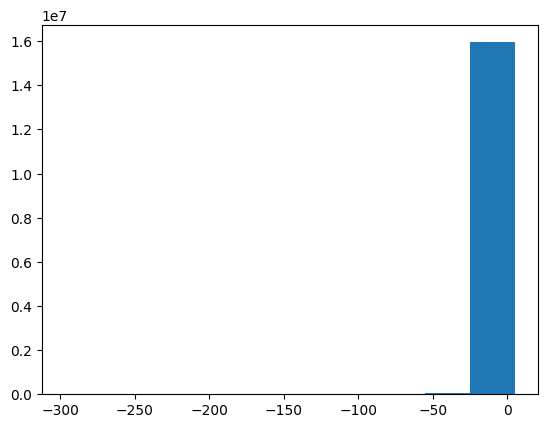

In [43]:
plt.hist(np.ravel(loglik_array))

In [50]:
np.unravel_index(loglik_array.argmin(),loglik_array.shape)

(414154, 0)

In [76]:
loglik_array[414154]

array([-297.260041  ,    4.15087704,    5.30953056,    5.42996968,
          4.9048068 ,    5.34177776,    5.43398155,    5.33127695])

In [60]:
loglik_array.shape

(1999999, 8)

In [63]:
test_set_28[414154:414155]

array([[[  20.78730897,  147.17100071],
        [ -10.01710764,  103.98312029],
        [   6.34975467, -124.85034243],
        [   8.3235972 , -104.68545094],
        [   6.46942709,   32.83393758],
        [   2.40507345,   34.78207175],
        [   2.94722132,  -11.74293504],
        [  11.35199524,  -54.17651649]]])

In [77]:
u_t = U(test_set_28[414153:414155,:,0],test_set_28[414154:414156,:,0],F=28)
X_poly = poly.fit_transform(test_set_28[414153:414155,:,0].reshape(-1,1))
U_d = reg.predict(X_poly).reshape(-1,k)
h_t = u_t - U_d
h_time_plus_one = h_t[1:,:]
h_time = h_t[:-1,:]

In [78]:
h_t

array([[14.15296175,  5.58239262, -4.68942128, -1.93607268,  0.33303964,
         1.52123127, -1.44010414, -1.90462574],
       [ 5.6185257 ,  6.05113111, -4.80961855, -1.99442258, -0.02925992,
         1.66571208, -1.3390979 , -1.70415676]])

In [79]:
loglik_rest = norm.logpdf(h_time_plus_one,loc=phi*h_time,scale=sigma*(1-phi**2)**0.5) -np.log(0.005) #scaling factor
loglik_rest

array([[-297.26272063,    4.15087458,    5.30953468,    5.4299738 ,
           4.90480616,    5.34178127,    5.43398531,    5.33127956]])

In [84]:
test_set_28[414153:414155,:,0]

array([[ 21.53453086,  -9.68090604,   5.59993703,   7.76528786,
          6.54410096,   2.4712509 ,   2.77589505,  11.03964602],
       [ 20.78730897, -10.01710764,   6.34975467,   8.3235972 ,
          6.46942709,   2.40507345,   2.94722132,  11.35199524]])

In [83]:
U_d

array([[ -0.85669275, -11.27188628,   6.78997894,   8.55298523,
          7.6267045 ,   3.42337249,   3.78371231,   9.98151431],
       [  0.91354894, -11.56191979,   7.46258548,   8.91155691,
          7.5641605 ,   3.34435158,   3.98378272,  10.02490506]])

In [82]:
u_t

array([[13.29626899, -5.68949366,  2.10055766,  6.61691255,  7.95974414,
         4.94460375,  2.34360816,  8.07688857],
       [ 6.53207464, -5.51078868,  2.65296693,  6.91713433,  7.53490058,
         5.01006366,  2.64468482,  8.32074831]])

In [37]:
test_set_28[:,:,0].max()

27.338758174861738

In [85]:
np.unravel_index(test_set_28[:,:,0].argmax(),test_set_28[:,:,0].shape)

(1758635, 5)

In [86]:
test_set_28[1758635,:,0]

array([ 7.2092242 ,  5.62799461, -1.45237158,  1.4530485 ,  9.46610167,
       27.33875817,  2.58694589, -8.13381548])

In [99]:
u_t = U(test_set_28[1758635:1758637,:,0],test_set_28[1758636:1758638,:,0],F=28)
X_poly = poly.fit_transform(test_set_28[1758635:1758637,:,0].reshape(-1,1))
U_d = reg.predict(X_poly).reshape(-1,k)
h_t = u_t - U_d
h_time_plus_one = h_t[1:,:]
h_time = h_t[:-1,:]

In [88]:
test_set_28[1758635:1758637,:,0]

array([[ 7.2092242 ,  5.62799461, -1.45237158,  1.4530485 ,  9.46610167,
        27.33875817,  2.58694589, -8.13381548],
       [ 7.10421643,  5.94694909, -1.46080987,  1.55002571,  9.74090266,
        27.26423127,  0.25947495, -8.07439214]])

In [90]:
u_t

array([[ 6.19144214,  6.74082166, -1.90187134,  1.53359535,  6.82121305,
        14.9812982 ,  5.16444232, -4.90560134],
       [ 6.16031903,  7.0948787 , -1.97181092,  1.73234348,  7.4255373 ,
        17.44185638,  2.28422951, -5.31292163]])

In [100]:
U_d

array([[  8.15440777,   6.81623134,  -1.57161075,   2.18113731,
          9.50510719, -21.26823178,   3.5608918 ,  -9.78422161],
       [  8.07469436,   7.10884433,  -1.58273291,   2.30170911,
          9.61796974, -20.92488886,   0.66620991,  -9.7225001 ]])

In [101]:
h_t

array([[-1.96296563e+00, -7.54096835e-02, -3.30260589e-01,
        -6.47541962e-01, -2.68389414e+00,  3.62495300e+01,
         1.60355052e+00,  4.87862028e+00],
       [-1.91437534e+00, -1.39656379e-02, -3.89078008e-01,
        -5.69365624e-01, -2.19243243e+00,  3.83667452e+01,
         1.61801960e+00,  4.40957847e+00]])

In [102]:
h_t[:,5]

array([36.24952998, 38.36674523])

In [108]:
u_t = U(test_set_28[1758600:1758600+500,:,0],test_set_28[1758600 + 1:1758600 + 1 + 500,:,0],F=28)
X_poly = poly.fit_transform(test_set_28[1758600:1758600+500,:,0].reshape(-1,1))
U_d = reg.predict(X_poly).reshape(-1,k)
h_t = u_t - U_d
h_time_plus_one = h_t[1:,:]
h_time = h_t[:-1,:]

loglik_rest = norm.logpdf(h_time_plus_one,loc=phi*h_time,scale=sigma*(1-phi**2)**0.5) -np.log(0.005) #scaling factor


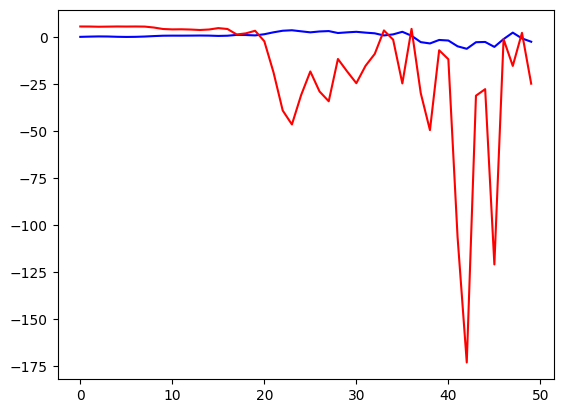

In [121]:
plt.plot((h_time_plus_one - phi*h_time)[:50,5],color="blue")
# plt.plot(h_t[:50,5],color="k")
plt.plot(loglik_rest[:50,5],color="red")

In [122]:
(h_time_plus_one - phi*h_time)[40:50,5]

array([-1.99770326, -5.06333679, -6.39786349, -2.90375394, -2.76330995,
       -5.38419974, -1.24410028,  2.19173402, -0.87817299, -2.6399213 ])

In [123]:
loglik_rest[40:50,5]

array([ -11.93842332, -106.32102653, -173.01097874,  -31.30178438,
        -27.83150615, -120.93729471,   -1.28639448,  -15.48271395,
          2.0997006 ,  -24.92459477])

In [125]:
norm.logpdf(h_time_plus_one[42,5],loc=phi*h_time[42,5],scale=sigma*(1-phi**2)**0.5)

-178.3092961081726

In [127]:
norm.logpdf(h_time_plus_one[43,5],loc=phi*h_time[43,5],scale=sigma*(1-phi**2)**0.5)

-36.6001017429702

Loglik depends on the differences between the hs. As long as the "true" hs change smoothly, loglik will be fine. Even if u makes a poor prediction, if the h required to correct it is not too different to the h at the previous time-step, log-lik will be ok.

# 3. Generate data

In [128]:
50000/0.005

10000000.0

In [129]:
10000000 /

10000000

In [130]:
1000 / 0.005

200000.0

In [134]:
1000 % 1000

0